<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC4</p>
<p style="margin: 0; text-align:right;">2020-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Series temporales y Combinación de clasificadores

Está práctica está dividida en dos partes:

 - En el primer ejercicio veremos como descomponer y componer series temporales para realizar predicciones a futuro. 
 - En el segundo ejercicio estudiaremos diferentes métodos de combinación de clasificadores.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nombre y apellidos:</strong>
</div>

Stefanie Kobsar Rodriguez

Para esta PEC se deben usar **únicamente las librerías que se importan a continuación**. Si se desea usar otra librería hay que consultarlo con el tutor/tutora del aula.

In [1]:
#!pip install statsmodels

In [2]:
import pickle

import scipy.stats
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib as mpl
from sklearn import svm
from sklearn import ensemble
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline

# 1. Series temporales

En este primer ejercicio trabajaremos las series temporales. 

Utilizaremos los datos de la [calidad del aire](http://mediambient.gencat.cat/es/05_ambits_dactuacio/atmosfera/qualitat_de_laire/principals_contaminants/index.html) del Eixample de Barcelona desde 2011, concretamente del contaminante dióxido de nitrógeno (NO2). Los datos son medidos por la Red de Vigilancia y Previsión de la Contaminación Atmosférica y se pueden obtener para otras estaciones, contaminantes y períodos [aquí](http://mediambient.gencat.cat/es/05_ambits_dactuacio/atmosfera/qualitat_de_laire/vols-saber-que-respires/descarrega-de-dades/index.html).

Empezaremos leyendo los datos:

In [3]:
df = pd.read_csv('NO2_Eixample_2011_2019.csv')
print("Number of rows and columns:", df.shape)
print("Column names:", list(df.columns))
df.head(3)

Number of rows and columns: (3214, 40)
Column names: ['codi_eoi', 'nom_estacio', 'data', 'magnitud', 'contaminant', 'unitats', 'tipus_estacio', 'area_urbana', 'codi_ine', 'municipi', 'codi_comarca', 'nom_comarca', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24', 'altitud', 'latitud', 'longitud', 'geocoded_column']


,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
0,8019043,Barcelona (Eixample),2014-10-03T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,60.0,60.0,36.0,39.0,70.0,70.0,67.0,95.0,97.0,106.0,92.0,86.0,102.0,90.0,84.0,93.0,92.0,68.0,70.0,100.0,95.0,97.0,81.0,69.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
1,8019043,Barcelona (Eixample),2014-09-02T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,26.0,32.0,45.0,48.0,40.0,50.0,47.0,67.0,68.0,67.0,62.0,61.0,62.0,65.0,46.0,49.0,60.0,59.0,70.0,80.0,74.0,61.0,37.0,20.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2,8019043,Barcelona (Eixample),2014-05-16T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,25.0,17.0,22.0,25.0,39.0,35.0,46.0,90.0,93.0,59.0,54.0,60.0,64.0,60.0,53.0,50.0,67.0,74.0,76.0,77.0,70.0,75.0,69.0,48.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Convertimos la columna "data" (=fecha) a tipo *datetime* y ordenamos los datos temporalmente:

In [4]:
df["data"] = pd.to_datetime(df["data"])
df.sort_values("data", inplace=True)
df.head(3)

,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
2912,8019043,Barcelona (Eixample),2011-01-17,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2704,8019043,Barcelona (Eixample),2011-01-18,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2805,8019043,Barcelona (Eixample),2011-01-19,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Vemos que, para cada fila, tenemos las medidas de N02 en µg/m3 para cada hora del día. Para simplificar el análisis, utilizaremos solamente la media diaria, que passamos a calcular: 

In [5]:
colNs_hourly_measurements = ["h%02d" % h for h in range(1,25)]
print(colNs_hourly_measurements)
df["mean_day"] = df[colNs_hourly_measurements].mean(axis=1)
df[["data", "mean_day"] + colNs_hourly_measurements].head()

['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']


,data,mean_day,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
2912,2011-01-17,98.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0
2704,2011-01-18,127.083333,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0
2805,2011-01-19,117.045455,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0
2969,2011-01-20,71.333333,92.0,88.0,84.0,72.0,74.0,59.0,65.0,65.0,78.0,65.0,62.0,68.0,59.0,58.0,59.0,69.0,73.0,80.0,82.0,70.0,70.0,74.0,67.0,79.0
2831,2011-01-21,75.875000,54.0,41.0,40.0,40.0,31.0,29.0,52.0,88.0,105.0,88.0,74.0,71.0,64.0,79.0,82.0,77.0,86.0,106.0,118.0,120.0,111.0,104.0,92.0,69.0


Hay días, como el primero del conjunto de datos, en los que muchas horas no tienen valores válidos. Esto puede resultar en medias diarias muy desviadas. Por tanto, eliminaremos los días con varias medidas inválidas:

In [6]:
print("Number of rows before:", df.shape[0])
df = df[df[colNs_hourly_measurements].isna().sum(axis=1)<5]
print("Number of rows after:", df.shape[0])

Number of rows before: 3214
Number of rows after: 3146


Representamos la serie temporal, compuesta sólo por la medida media que hemos creado, y como índice la columna que nos indica la fecha:

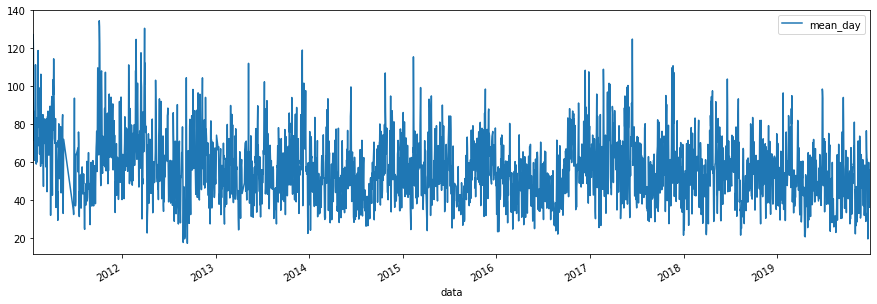

In [7]:
data = df[["data", "mean_day"]].set_index("data")
data.plot(figsize=(15, 5))
plt.show()

Vemos que la variación diaria introduce mucho ruido que no es interesante para analizar la evolución temporal del contaminante en una escala temporal más larga. Por consiguiente, utilizaremos la media de la medida para cada mes en vez de los valores diarios:

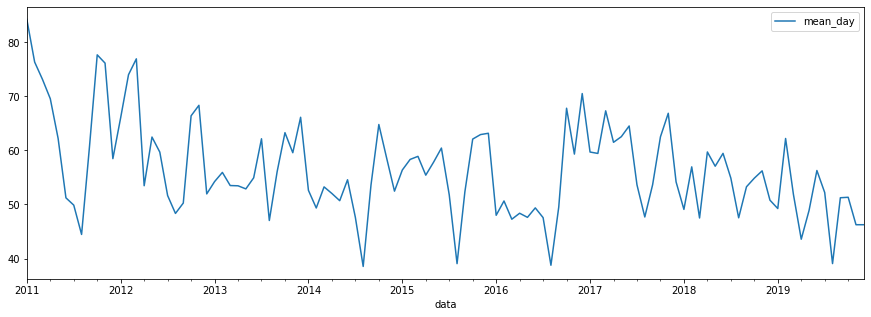

In [8]:
data = df[["data", "mean_day"]].set_index("data").resample("1M").mean()
data.plot(figsize=(15, 5));

Como se puede apreciar, la serie temporal de este contaminante es bastante irregular, pero se intuye cierta heterocedasticidad, tendencia, periodo y ruido, los cuales analizaremos a lo largo de este ejercicio.

Antes de empezar a tratar las diferentes componenetes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.

In [9]:
date_min_test = "2018-01-01"
TEST_SIZE = len(data[data.index>=date_min_test])
# train and test are dataframes that contain the values and a datetime index:
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
# x_train and x_test only contain the values:
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((84, 1), (84,), (24, 1), (24,))

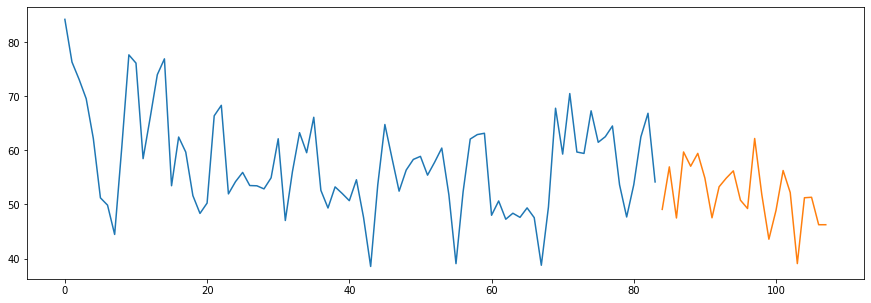

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)
plt.show()

## 1.1 Componentes de la serie temporal

### 1.1.a. Heterocedasticidad (0.5 puntos)

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad). En nuestro caso, observamos que tenemos una cierta heterocedasticidad, ya que la amplitud de onda disminuye ligeramente con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Transformación de los datos para eliminar la heterocedasticidad. Para hacerlo debéis transformar los datos aplicando la función que consideréis que elimina mejor la heterocedasticidad en el dataset, provad con las tres funciones siguientes: 

- exponencial
- logarítmica
- raiz cuadrada
    
y decidid cual de las tres funciona mejor para eliminar la heterocedasticidad. Estas funciones ya están implementadas en <i>numpy</i>. 
    
Mostrad gráficamente el dataset transformado.
</div>

Para disminuir la heterocedasticidad 

In [11]:
log_no2 = np.log(data)
exp_no2 = np.exp(data)
sq_no2 = np.sqrt(data)


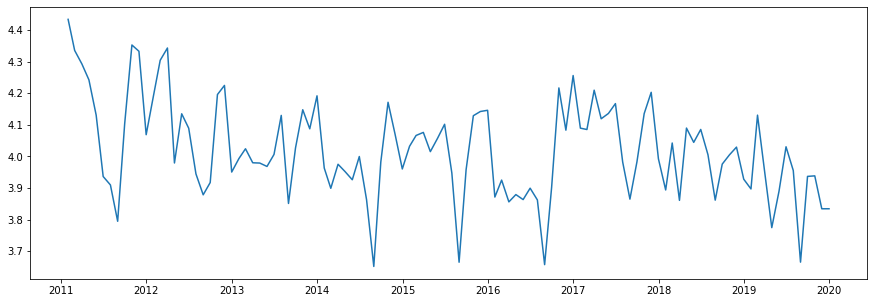

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(log_no2)
plt.show()


La transformación logarítmica disminuye la heterocedasticidad al orden 10^-1

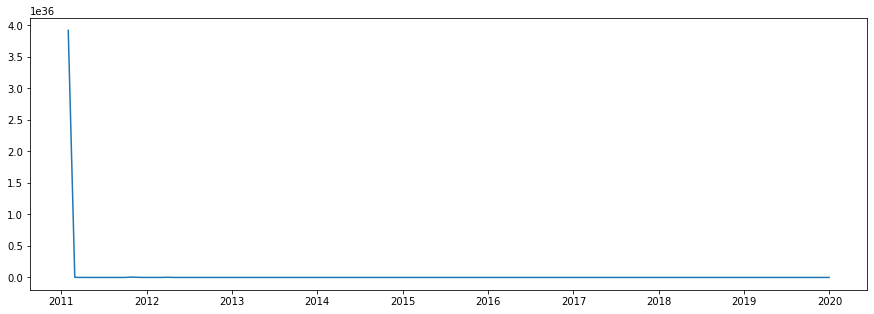

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(exp_no2)
plt.show()

In [14]:
exp_no2.head()

,mean_day
data,
2011-01-31,3.920173e+36
2011-02-28,1.450460e+33
2011-03-31,5.891938e+31
2011-04-30,1.639143e+30
2011-05-31,1.054521e+27


La transformación exponencial introduce una mayor heterocedasticidad, ya que la escala en la que se trabaja es del orden de 10^+36

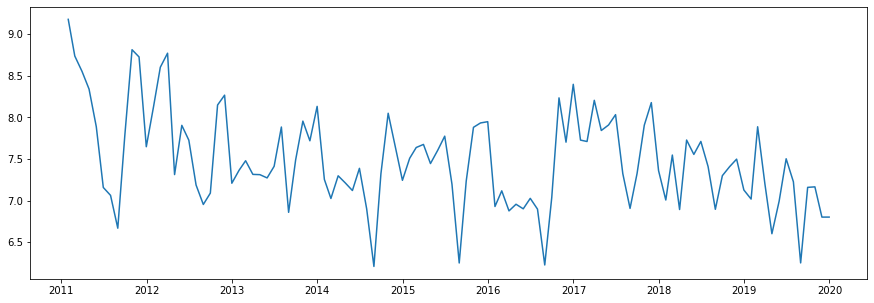

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(sq_no2);

La transformación cuadrática disminuye la heterocedasticidad al orden de magnitud de las unidades. 


La transformación más adecuada en este caso será la transformación logarítmica, ya que es con la que se consigue una menor variabilidad en la varianza y conserva significativamente la tendencia de los datos

### 1.1.b. Tendencia (0.7 puntos)

La tendencia es el comportamento que tiene los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una ligera tendencia lineal decreciente (mejor para nuestra salud). En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Como observando la serie podemos apreciar que tenemos una ligera tendencia lineala a la baja:
    - Ajustad una regresión lineal a los datos (con la heterocedasticidad ya eliminada). Esta será la tendencia que asumimos que tienen los datos.
    - Eliminad la tendencia de los datos, sustrayendola a los datos que ya tienen la heterocedasticidad eliminada.
    - Mostrad gráficamente los datos sin tendencia.
<br><br>

<u>Sugerencia</u>: usad el módulo *LinearRegression* de *sklearn*. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
</div>

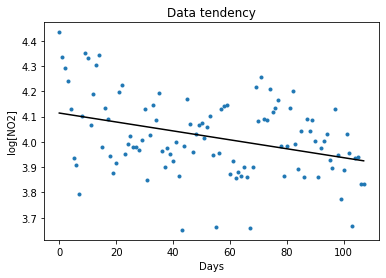

In [16]:
X = data.reset_index().index.values
X = np.reshape(X, (len(X), 1))
y = log_no2.to_numpy()

reg = LinearRegression().fit(X, y)

trend_pred = reg.predict(X)

plt.scatter(X, y, marker=".")
plt.plot(X, trend_pred,color='k')
plt.title("Data tendency")
plt.xlabel("Days")
plt.ylabel("log[NO2]")

plt.show()

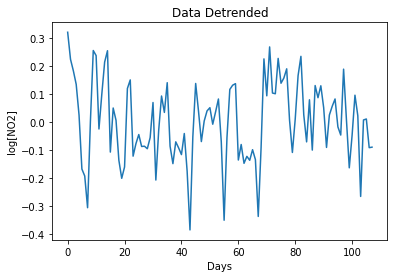

In [17]:
detr = [y[i] - trend_pred[i] for i in range(0, len(y))]
plt.plot(detr)
plt.title('Data Detrended')
plt.xlabel("Days")
plt.ylabel("log[NO2]")
plt.show()

In [18]:
r2 = r2_score(y, trend_pred)
mae = np.sqrt(mean_absolute_error(y, trend_pred))
print('r2:', r2)
print('mae:', mae)

r2: 0.13020056484795883
mae: 0.3404271728180803


### 1.1.c. Estacionalidad (0.7 puntos)

Definimos estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad). En este apartado se debe encontrar la estacionalidad, la cual eliminaremos en el siguiente ejercicio. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
En primer lugar tenéis que encontrar el ciclo, es decir, cada cuando se repiten los datos. Para encontrarlo podéis usar l'autocorrelación (<i>numpy</i> te permite obtener los coeficientes de correlación). La idea es que se tiene que comparar:
    
- La serie original con la serie empezando en el segundo punto (es decir, serie[1:])
- La serie original con la serie empezando en el tercer punto (es decir, serie[2:])
- ...
    
En el momento en que vuelva a empezar el ciclo, la serie será muy parecida a la serie original, y, por lo tanto, la correlación será muy elevada. El punto donde la correlación sea máxima, será el ciclo de la serie. 

Mostrar gráficamente los coeficientes de los 22 primeros valores de autocorrelación y determinar su valor máximo, este será nuestra estacionalidad.
    
<u>NOTA</u>: Si usais <i>numpy</i> para encontrar los coeficientes de correlación, las dos series que comparéis deben de tener la misma longitud. Para representar la serie original podéis eliminar los valores del final para que tenga la misma longitud que la serie "movida". Por ejemplo, en el primer caso podéis comparar serie[1:] con serie[:-1].
</div>

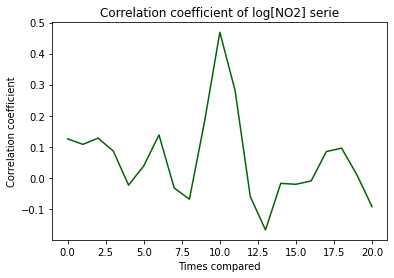

In [19]:
index_values = list(range(2, 23))
list_coef = []

for index in index_values:
    serie_original = log_no2[index:].values.tolist()
    serie_mod = log_no2[:-index].values.tolist()
    corr = np.corrcoef(serie_original, serie_mod, rowvar= False)
    coef = corr[0][1]
    list_coef.append(coef)

plt.plot(list_coef, color="darkgreen")
plt.title("Correlation coefficient of log[NO2] serie")
plt.xlabel("Times compared")
plt.ylabel("Correlation coefficient");

Se elimina el valor de correlación para la comparación serie[1:] con serie[:-1] ya que nos da el valor máximo para los coeficientes de correlación, como cabía esperar. 

In [20]:
max_coef = max(list_coef)

In [21]:
index_coef = list_coef.index(max_coef)

print(f"Comparar la lista original con la lista empezando en el punto {index_coef} se obtiene el máximo valor de correlación")

Comparar la lista original con la lista empezando en el punto 10 se obtiene el máximo valor de correlación


Test estadístico para determinar la estacionalidad: test de Dickey-Fuller aumentado

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

### 1.1.d. Aplicar un modelo SARIMA (0.8 puntos)

Para tratar la estacionalidad aplicaremos un modelo SARIMA. Las siglas corresponden a "stationality ARIMA", es decir, un modelo ARIMA con estacionalidad (la que acabamos de encontrar).

El modelo ARIMA nos va a permitir tratar el ruido que queda al eliminar la heterocedasticidad, tendencia y estacionalidad. Para hacerlo tiene en cuenta las siguientes componentes:

- AR: auto-regressive, se denomina *p*. Tiene en cuenta la correlación con sus lags, es decir, mira si las observaciones pasadas afectan para calcular el siguiente punto. 
- I: integrated, se denomina *d*. Es el orden de diferenciación, en nuestro caso no es necesario, puesto que la serie ya no tiene heterocedasticidad ni tendencia.
- MA: moving-average, se denomina *q*. Tiene en cuenta la correlación con los lags de los errores, es decir, una vez se ha aplicado el modelo, mira los errores del modelo versus los datos reales.

Para más información sobre los ARIMA podéis consultar este link: https://otexts.com/fpp2/arima.html

Los modelos SARIMA dependen de varios parámetros (p,d,q)(P,D,Q)s, donde los primeros (minúsculas) corresponden a AR, I, MA de la serie normal, u los segundos (mayúsculas) a AR, I, MA con estacionalidad. 

Para encontrar estos parámetros tenemos que mirar los gráficos PACF (<i>partial autocorrelation function</i>) y ACF (<i>autocorrelation function</i>).

El gráfico PACF nos determina el parámetro *p*, es decir, la AR.

In [40]:
train_log_trend = log_no2

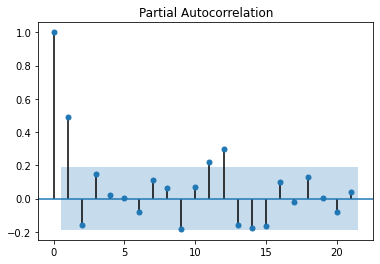

In [41]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_log_trend

plot_pacf(train_log_trend)
plt.show()

Para leer este gráfico, simplemente nos tenemos que fijar en los valores que salen fuera del intervalo de confianza (zona azul).

Nada mas empezar hay dos valores fuera del intervalo. De todos modos el primero no se debe tener en cuenta, puesto que mira la correlación de un valor consigo mismo, y esta siempre será 1. Si no tenemos en cuenta este primer valor, en el primer ciclo (primeros 12 puntos) hay tres valores fuera del intervalo de confianza, pero uno de ellos justo en la frontera, con lo cual escogemos **p = 2**. También podríamos probar con p=1 o p=3.

Cuando se repite el ciclo, es decir, a partir del valor 11, hay tres valores claramente fuera del intervalo, con lo cual **P = 3**. También podríamos probar con P=2 o p=4.

Veamos ahora el gráfico ACF, este determinará el valor de *q*.

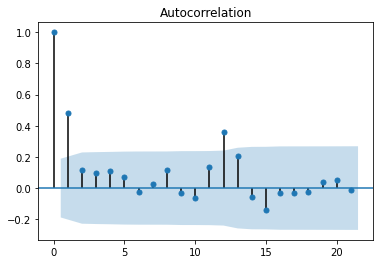

In [42]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_log_trend
plot_acf(train_log_trend)
plt.show()

Este gráfico se lee igual que el anterior. 

Ignorando el primer lag, vemos que al empezar hay un valor fuera del intervalo, con lo cual **q = 1**. Cuando se repite el ciclo, es decir, a partir del valor 11, solo hay un valor fuera del intervalo, con lo cual **Q = 1**.

Como los datos no tienen ni tendencia ni heterocedasticidad, **d = D = 0**.

Como hemos visto en el apartado anterior, el ciclo es 12, con lo cual **s = 12**.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Aplica un modelo SARIMA a los datos sin heterocedasticidad ni tendencia. Puedes usar SARIMAX (de <i>statsmodels.tsa.statespace.sarimax</i>) con los parámetros que acabamos de ver. 
    
Mostrar gráficamente el resultado del modelo en el dataset de train junto con la serie original para comparar si se ajusta bien.
</div>

## 1.2. Predicción

Vamos a predecir los dos proximos años y comparar la predicción con los datos reales. Seguiremos los siguientes pasos:

   - Generar la predicción con el SARIMA
   - Añadir tendencia
   - Añadir heterocedasticidad

### 1.2.a. Predicción SARIMA (0.5 puntos)

Utilizaremos el modelo SARIMA que hemos fitado antes para predecir los dos próximos años.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Genera las previsiones para dos años de test mediante el modelo SARIMA fitado en el apartado anterior.

Haz un gráfico de toda serie temporal (sin heterocedasticidad ni tendencia), diferenciando con dos colores diferentes la serie real en el conjunto de train y las previsiones del modelo en los dos años del conjunto de test.
</div>

### 1.2.b. Tendencia (0.5 puntos)

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Añade a la serie anterior de previsiones del modelo la tendencia que habíamos eliminado en el apartado 1.1.b.

Haz un gráfico de toda serie temporal, sin heterocedasticidad pero con tendencia, diferenciando con dos colores diferentes la serie real en el conjunto de train y las previsiones del modelo en los dos años del conjunto de test.
</div>

### 1.2.c. Heterocedasticidad (0.5 puntos)

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>
    
Añade a la serie anterior de previsiones del modelo (a la que ya ha recuperado la tendencia), la heterocedasticidad que habíamos eliminado en el apartado 1.1.a, aplicando la función inversa a la aplicada anteriormente. 
    
Mostrar gráficamente toda la serie, esta vez ya con heterocedasticidad y tendencia,  diferenciando con colores diferentes la serie real de los dos años de predicción. 
</div>

### 1.2.d. Precisión del modelo (0.8 puntos)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Añade al gráfico anterior la serie real para los dos años de predicción.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>    

Calcula la precisión del modelo en el conjunto de test con las métricas R2 y Mean Absolute Error.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> ¿Que te parecen los resultados obtenidos por el modelo, tanto visualmente como analizando los valores de las métricas calculadas?
</div>

# 2. Combinación de clasificadores

Para este ejercicio usaremos un subconjunto de 5.000 imágenes Fashion MNIST, proporcionado por Zalando, correspondientes a 5 tipos de prendas de ropa distintos: "T-shirt", "Trouser", "Pullover", "Dress" y "Coat".

A la primera parte de este ejercicio veremos la combinación de clasificadores en paralelo mediante las tecnicas de 
**_Bagging_** y **_Boosting_**.

La segunda parte pretende mejorar los resultados aplicando tecnicas de combinación secuencial de clasificadores: **_Stacking_** y **_Cascading_**.

Para empezar, vamos a visualizar el dataset. Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones. El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels, y mostrará un ejemplo de imagen de cada una de las clases:

Shape of images vector: (5000, 784)
Shape of labels vector: (5000,)


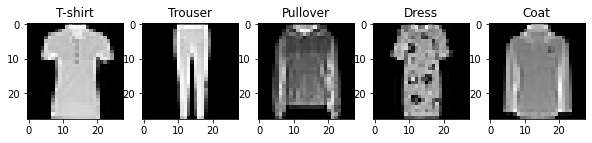

In [25]:
# Load data:
with open("data_MNIST.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

print("Shape of images vector: {}".format(images.shape))
print("Shape of labels vector: {}".format(labels.shape))

# Plot images with labels:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

Para poder probar varios modelos, primero vamos a dividir el dataset entre train y test.

La división con la funció *train_test_split* es aleatoria , pero para que todos obtengáis los mismos resultados y poder comentar dudas por el foro, fijaremos la seed para obtener los mismos datasets de train y test. L'*split* tendrá en cuenta que los dos conjuntos tengan el mismo número de ejemplos para cada una de las clases, gracias al parámetro *stratify=labels*.

Como en la segunda parte de este ejercicio trataremos *stacking* y *cascading*, y ambos se aplican sobre el conjunto de test, haremos un *split* del 50% para tener un poco más de base al aplicar estas dos técnicas.

In [47]:
myseed = 13

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5,
                                                    random_state=myseed, 
                                                    stratify=labels)

## 2.1. Combinación paralela de clasificadores

### 2.1.1. Árbol de decisión (0.5 puntos)

Para poder comparar el aumento de *performance* obtenido a medida que aplicamos técnicas nuevas, utilizaremos como *baseline* un simple árbol de decisión.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Evalua la precisión de un árbol de decisión con profundidad máxima de 5 niveles (aplicaremos la misma restricción en las siguientes secciones) aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
       
<u>Sugerencia</u>: usar el módulo *cross_val_score* de *sklearn*. Para aprender más sobre *cross validation* y sobre como usar estos módulos, os recomendamos los siguientes enlaces: 
- http://scikit-learn.org/stable/modules/cross_validation.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

clf = DecisionTreeClassifier(random_state=0, max_depth=5)
print("crossvalidation", cross_val_score(clf, X_train, y_train, cv=15))
clf.fit(X_train, y_train)
preds_tree = clf.predict(X_test)
print("test", precision_score(y_test, preds_tree, average='weighted'))

crossvalidation [0.79411765 0.80588235 0.75882353 0.82352941 0.73529412 0.80606061
 0.8        0.8        0.76363636 0.76363636 0.82424242 0.77575758
 0.73939394 0.73333333 0.79393939]
test 0.791018981407934


### 2.1.2. *Bagging*

#### 2.1.2.a. Random Forest (0.7 puntos)

La idea básica del bagging es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo Random Forest, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (la Random Forest) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
        
Evalua la precisión de un <i>random forest</i> combinando 20 árboles de decisión con profundidad máxima de 5 niveles aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Per apender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

clf = RandomForestClassifier(max_depth=5, n_estimators=20, random_state=0) 
print("crossvalidation", cross_val_score(clf, X_train, y_train, cv=15))
clf.fit(X_train, y_train)
preds_bagging = clf.predict(X_test)
print("test", precision_score(y_test, preds_bagging, average='weighted'))

crossvalidation [0.82941176 0.81764706 0.78823529 0.81176471 0.76470588 0.81818182
 0.8        0.84242424 0.83030303 0.81818182 0.78787879 0.81212121
 0.79393939 0.81212121 0.80606061]
test 0.8213752377018356


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Han mejorado los resultados respecto a un simple árbol de decisión? Era de esperar?
</div>

Los resultados han mejorado lo que era de esperar porque estamos combinando varios arboles; los que nos da más poder predictivo que usar solo uno de ellos. Las carencias de un árbol son cubiertas por el otro dentro de los límites del método. 

#### 2.1.2.b. Out-of-bag (0.5 puntos)

Una ventaja del *bagging* usado en el *Random Forest* es que cada uno de los árboles de decisión ha sido entrenado con una combinación diferente de los datos (muestreo con reemplazo), o sea que cada uno de los árboles no ha visto una determinada parte de los datos originales. Esto define una especie de conjunto de test para cada uno de los árboles, llamado *out-of-bag*, que puede ser usado para estimar el error del modelo sin necesidad de usar el conjunto de test real que creamos previamente, ni de usar estrategias de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
      
Entrena sobre el conjunto de train un modelo de <i>random forest</i>combinando 20 árboles de decisión con profundidad máxima de 5 niveles y muestra la precisión de este modelo en el *out-of-bag*.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender más sobre *out-of-bag* y sobre como usar este módulo (incluyendo el atributo *oob&#95;score_*), os recomendamos los siguientes enlaces:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

</div>

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

clf = RandomForestClassifier(max_depth=5, n_estimators=20, oob_score=True, random_state=0) 
print("crossvalidation", cross_val_score(clf, X_train, y_train, cv=15))
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print("test", precision_score(y_test, preds, average='weighted'))

crossvalidation [0.82941176 0.81764706 0.78823529 0.81176471 0.76470588 0.81818182
 0.8        0.84242424 0.83030303 0.81818182 0.78787879 0.81212121
 0.79393939 0.81212121 0.80606061]
test 0.8213752377018356


In [51]:
clf.oob_score_

0.8024

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> La precisión obtenida en el <i>out-of-bag</i> y con los métodos de validación anteriores son comparables? Era de esperar? 
</div>

La precision en el oob_score es comparabl ya que al final aunque no enseñemos todos los datos el conjunto de todos los arboles entrenedas con bootstrat tendria que tender hacia el mismo resultado.

#### 2.1.2.c. Número de clasificadores agregados (0.5 puntos)

En los ejercicios anteriores hemos combinado 20 clasificadores simples en nuestro clasificador combinado. Será que la precisión del clasificador combinado aumenta indefinidamente su desempeño si añadimos más clasificadores?

Para responder a esta pregunta vamos a representar una curva de validación. La curva de validación es una representación gráfica del desempeño de un modelo variando uno de sus parámetros. Esto nos permite entender cuál es el impacto de un determinado parámetro en el desempeño de un modelo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>    
    
Entrena varios modelos de <it>Random Forest</it> con un número de árboles cada vez mayor. Para cada modelo, calcula su precisón en el conjunto de test o usando *cross-validation* en el conjunto de entrenamiento. Opcional: representa gráficamente la evolución de la precisión con el número de árboles para ayudarte en el análisis de los resultados.
<br><br>
    
<u>Sugerencia</u>: usar el módulo *validation_curve* de sklearn. Para aprender a usar este módulo os recomendamos los siguientes enlaces:<br>
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
- http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

In [31]:
from sklearn.model_selection import validation_curve

params = [10, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
clf = RandomForestClassifier(max_depth=5, n_estimators=20, random_state=0) 
train_scores, valid_scores = validation_curve(clf, images, labels, "n_estimators", params, cv=5)

In [32]:
valid_scores.shape, train_scores.shape

((11, 5), (11, 5))

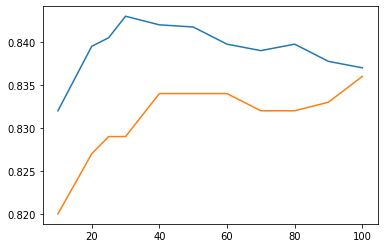

In [33]:
plt.plot(params, train_scores[:, 0])
plt.plot(params, valid_scores[:, 0])

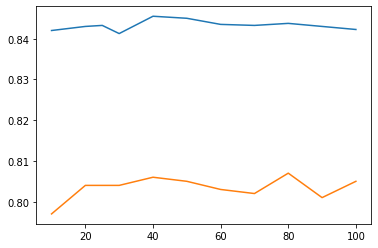

In [34]:
plt.plot(params, train_scores[:, 1])
plt.plot(params, valid_scores[:, 1])

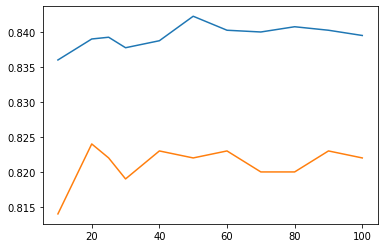

In [35]:
plt.plot(params, train_scores[:, 2])
plt.plot(params, valid_scores[:, 2])

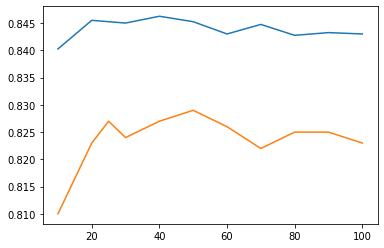

In [36]:
plt.plot(params, train_scores[:, 3])
plt.plot(params, valid_scores[:, 3])

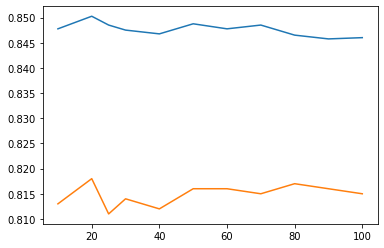

In [37]:
plt.plot(params, train_scores[:, 4])
plt.plot(params, valid_scores[:, 4])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Incrementa indefinidamente la precisión con el número de árboles combinados, o satura en una precisión límite? Porqué?
</div>

No, a cierto punto empezamos tener una tendencia logarítmica de aprendizaje. Se observa que en algunos casos con más árboles empeora. Podría ser un indicador de sobreentrenamiento. Al final más clasificadores, significan más parámetros, y por tanto la complejidad del algoritmo pasa a ser demasiado grande para los datos que tenemos, produciendo que aprendamos los datos del entrenamiento pero no la tendencia general, bajando la validación mientra el resultado del train se mantiene.

### 2.1.3. *Boosting* (0.8 puntos)

En el sistema de Boosting se combinan varios clasificadores débiles sequencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificados en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>

Evalua la precisión de un <i>gradient boosting</i> con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i> aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *GradientBoostingClassifier* de sklearn. Per apender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

In [122]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

clf = GradientBoostingClassifier(max_depth=5, n_estimators=20, n_iter_no_change=20, random_state=0) 
print("crossvalidation", cross_val_score(clf, X_train, y_train, cv=5))
clf.fit(X_train, y_train)
preds_boosting = clf.predict(X_test)
print("test", precision_score(y_test, preds_boosting, average='weighted'))


crossvalidation [0.864 0.84  0.85  0.832 0.832]
test 0.8556179336726784


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Han mejorado los resultados respecto a un simple árbol de decisión? Era de esperar?
</div>

Los resultados han mejorado, era de esperar ya que estamos entrenando varios trees que se centran el los datos errados anteriormente, dandole al modelo final más poder de prediccion


## 2.2. Combinación secuencial de clasificadores base diferentes

Para poder hacer combinación secuencial de modelos, necessitamos tener varios modelos diferentes entrenados. 

En nuestro caso, ya tenemos un árbol de decisión, el *random forest* y el *gradient boosting*. Vamos a entrenar un par de modelos más.

### 2.2.1 Clasificadores adicionales (0.5 puntos)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Entrena un <i>k-neighbors</i> con 2 vecinos sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 

Entrena un SVM (Suport vector machines) con gamma = 0.07 sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 
</div>  

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

clf = KNeighborsClassifier(n_neighbors=2)
print("crossvalidation", cross_val_score(clf, X_train, y_train, cv=15))
clf.fit(X_train, y_train)
preds_k = clf.predict(X_test)
print("test", precision_score(y_test, preds_k, average='weighted'))

crossvalidation [0.80838323 0.78443114 0.80239521 0.83832335 0.80239521 0.80838323
 0.81437126 0.83233533 0.80239521 0.77245509 0.79518072 0.80120482
 0.81325301 0.8373494  0.78915663]
test 0.8293726007878115


In [125]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

clf = svm.SVC(gamma=0.07, random_state=0) 
print("crossvalidation", cross_val_score(clf, X_train, y_train, cv=15))
clf.fit(X_train, y_train)
preds_svm = clf.predict(X_test)
print("test", precision_score(y_test, preds_svm, average='weighted'))

crossvalidation [0.8742515  0.86227545 0.85628743 0.8742515  0.81437126 0.86826347
 0.8742515  0.85628743 0.84431138 0.89820359 0.85542169 0.88554217
 0.86746988 0.86144578 0.85542169]
test 0.8665395092306138


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Han mejorado los resultados respecto a un simple árbol de decisión? Era de esperar?
</div>

Sí, no tendria porque ser de esperar, depende del tipo de dataset que tenemos podria ser que un DecisionTree fuera mejor que un KNeighbours o que un supportvector machine. En este caso al tener muchas dimensiones a lo mejor sí que esperariamos que un SVM funcionara un poco mejor que un simple Kneighbours o un decisionTree pero no es algo a esperar 100%

### 2.2.2 *Stacking* (0.7 puntos)

Un clasificador de *stacking* usa como atributos las predicciones hechas por otros clasificadores en lugar de los datos originales de entrada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>stacking</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones hechas en el conjunto de test por los algoritmos: 
    
- árbol de decisión
- random forest
- gradient boosting
- knn
- svm 
 
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test (en este caso no tenemos conjunto de train, con lo cual se hace directamente cross-validation sobre test).

<u>Sugerencia</u>: usar la función column_stack de numpy para juntar todas las predicciones. Dado que las variables que usaremos ahora como predictors son categóricas, es preferible transformarlas en *dummies* (*one-hot-encoding*). Para apender a usar estas funciones os recomendamos los siguientes enlaces:
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
</div>

In [140]:
from sklearn.preprocessing import OneHotEncoder
X = np.column_stack([preds_tree, preds_bagging, preds_boosting, preds_k, preds_svm])

In [160]:
result = cross_val_score(clf, X, y_test, cv=15, scoring='precision_weighted')
print("crossvalidation", result)

print("Mean crossval", np.mean(result))
print("Std crossval", np.std(result))

crossvalidation [0.87671009 0.88304604 0.8791576  0.89158981 0.86037032 0.87304721
 0.88518042 0.87792775 0.89858314 0.86451672 0.86550662 0.89777218
 0.87886629 0.88533023 0.84064439]
Mean crossval 0.8772165870166567
Std crossval 0.014590533378460934


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> Has conseguido mejorar la precisión gracias al <i>stacking</i>? Comenta los resultados.
</div>

Sí,  podemos ver como la average ha subido pero con una std menor, queriendo decir que tenemos un algoritmo más reliable en los diferentes splits de train/test en el cross validation

### 2.2.3. *Cascading* (0.8 puntos)

El caso de *cascading* es parecido al de *stacking* pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>cascading</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones obtenidas con los modelos anteriores en el conjunto de test (igual que con el <i>stacking</i>), y también las variables originales. 
    
Calcula la precisión del modelo resultante con *cross-validation* en e conjunto de test.

<u>Sugerencia</u>: Usa el mismo conjunto de datos que en el ejercicio anterior pero añade `X_test`.
</div>

In [156]:
X = np.column_stack([preds_tree, preds_bagging, preds_boosting, preds_k, preds_svm, X_test])

In [161]:
result = cross_val_score(clf, X, y_test, cv=15, scoring='precision_weighted')
print("crossvalidation", result)

print("Mean crossval", np.mean(result))
print("Std crossval", np.std(result))

crossvalidation [0.87671009 0.88304604 0.8791576  0.89158981 0.86037032 0.87304721
 0.88518042 0.87792775 0.89858314 0.86451672 0.86550662 0.89777218
 0.87886629 0.88533023 0.84064439]
Mean crossval 0.8772165870166567
Std crossval 0.014590533378460934


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> Has conseguido mejorar la precisión gracias al <i>cascading</i>? Comenta los resultados.
</div>

Sí, es de esperar que mejoremos el resultado inicial del árbol de decisión simple pero también el stacking ya que vamos un paso más alla, dado que el cascading añade los valores iniciales, dejando que el clasificador busque un relacion no sólo entre las prediciones de los clasificadores solos pero entre estas y las features iniciales.

### Conclusion

En general vemos que los metodos de stacking i cascading ayudan a mejorar la precision en average pero también a bajar la standard deviation haciendo más robusto el predictor final. Esto es debido a que juntan diferentes algoritmos de naturalidad matemática muy diferente  los combinan entre ellos añadiendo también relaciones con los datos iniciales. Aún así hay que intentar vigilar de no hacer sobre entrenamiento ya que podría pasar en algunos casos